## LSLGA-Gaia

The goal of this notebook is to develop a set of cuts that we can use to find galaxies which will otherwise be "forced PSF" in DR9.

In [1]:
import os, pdb
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from astropy.table import vstack, Table

In [2]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.6)
%matplotlib inline

In [3]:
dr8dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/'
outdir = '/global/project/projectdirs/desi/users/ioannis/dr8-gaia-lslga'

#### First, read the set of SDSS galaxies that would be forced PSF.

In [36]:
def read_gaia_psf_sdss(clobber=False):
    outfile = os.path.join(outdir, 'dr8-gaia-psf-sdss.fits')
    if os.path.isfile(outfile) and not clobber:
        out = Table.read(outfile)
        print('Read {} galaxies from {}'.format(len(out), outfile))
    else:
        sdss = fitsio.read('/global/cfs/cdirs/cosmo/work/sdss/cats/specObj-dr14.fits')
        out = []
        for region in ('north', 'south'):
            print('Working on {}'.format(region))
            ext = fitsio.read(os.path.join(dr8dir, region, 'external', 
                                           'survey-dr8-{}-specObj-dr14.fits'.format(region)))
            keep = np.where((ext['GAIA_PHOT_G_MEAN_MAG'] > 0) * 
                            (ext['GAIA_PHOT_G_MEAN_MAG'] < 18) * 
                            (ext['GAIA_ASTROMETRIC_EXCESS_NOISE'] < 10.**0.5) * 
                            (ext['FLUX_W1'] > 0) * 
                            (ext['FLUX_R'] > 0) * 
                            ((sdss['PRIMTARGET'] & 2**6) != 0) * 
                            (sdss['Z'] > 0.001) * (sdss['Z'] < 1) * 
                            (sdss['ZWARNING'] == 0))[0]
            if len(keep) > 0:
                out.append(Table(ext[keep]))
        out = vstack(out)
        out.write(outfile, overwrite=True)
    return out               

In [37]:
%time specz = read_gaia_psf_sdss(clobber=False)

Read 631 galaxies from /global/project/projectdirs/desi/users/ioannis/dr8-gaia-lslga/dr8-gaia-psf-sdss.fits
CPU times: user 143 ms, sys: 4.41 ms, total: 147 ms
Wall time: 203 ms


#### Next, assemble the full catalog of forced-PSF Gaia sources from DR8.

Merge the sweeps together that were generated using `/global/cfs/cdirs/desi/users/ioannis/dr8-gaia-lslga/build-gaia-psf`.

In [8]:
def read_gaia_psf(clobber=False):    
    outfile = os.path.join(outdir, 'dr8-gaia-psf.fits')
    if os.path.isfile(outfile) and not clobber:
        out = Table(fitsio.read(outfile))
        print('Read {} objects from {}'.format(len(out), outfile))
    else:
        out = []
        for region in ['north', 'south']:
            print('Working on {}'.format(region))
            sweepdir = os.path.join(outdir, 'sweep-{}-gaia'.format(region))
            catfile = glob(os.path.join(sweepdir, 'sweep*.fits'))
            for ii, ff in enumerate(catfile):
                if ii % 50 == 0:
                    print('{} / {}'.format(ii, len(catfile)))
                cc = fitsio.read(ff)
                if len(cc) > 0:
                    out.append(Table(cc))
        out = vstack(out)
        print('Writing {} objects to {}'.format(len(out), outfile))
        out.write(outfile, overwrite=True)
    return out

In [9]:
%time cat = read_gaia_psf(clobber=False)

Working on north
0 / 237
50 / 237
100 / 237
150 / 237
200 / 237
Working on south
0 / 422
50 / 422
100 / 422
150 / 422
200 / 422
250 / 422
300 / 422
350 / 422
400 / 422
Stacking...
Writing 22252927 objects to /global/project/projectdirs/desi/users/ioannis/dr8-gaia-lslga/dr8-gaia-psf.fits
CPU times: user 5min 43s, sys: 54.3 s, total: 6min 37s
Wall time: 6min 57s


### Make some plots and develop the selection.

[-1.66666667  2.11666667] [2.20713305e-17 1.20000000e+00]
2035 22252927 9.144864403680469e-05


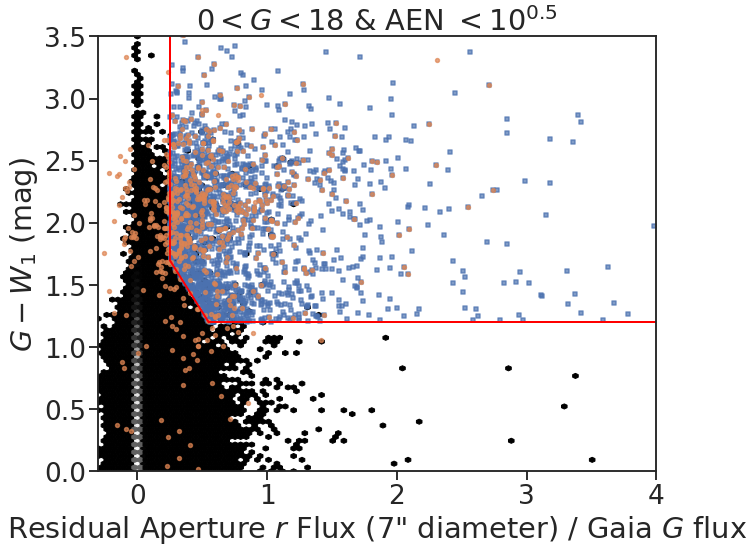

In [30]:
def getmags(cat):
    gmag = cat['GAIA_PHOT_G_MEAN_MAG']
    bp = cat['GAIA_PHOT_BP_MEAN_MAG']
    rp = cat['GAIA_PHOT_RP_MEAN_MAG']
    rmag = 22.5-2.5*np.log10(cat['FLUX_R'])
    Wmag = 22.5-2.5*np.log10(cat['FLUX_W1'])
    resid = cat['APFLUX_RESID_R'][:, 5]/10**(-0.4*(gmag-22.5))
    #resid = cat['APFLUX_RESID_R'][:, 7]/cat['FLUX_R']
    chi2 = cat['RCHISQ_R']
    return gmag-Wmag, bp-rp, resid, chi2

gW, bprp, resid, chi2 = getmags(cat)
sgW, sbprp, sresid, schi2 = getmags(specz)

xlim, ylim = (-0.3, 4), (0, 3.5)

# north cuts
#x0, x1, x2, x3 = (0.2, 0.2, 0.55, 5.0)
#y0, y1, y2, y3 = (  _, 1.7, 1.0, 1.0)
# north/south
x0, x1, x2, x3 = (0.25, 0.25, 0.55, 5.0)
y0, y1, y2, y3 = (  _, 1.7, 1.2, 1.2)

c1 = np.polyfit([x1, x2], [y1, y2], 1)
c2 = np.polyfit([x2, x3], [y2, y3], 1)
print(c1, c2)

J = np.where((resid > x0) * (gW > np.polyval(c1, resid)) * (gW > np.polyval(c2, resid)))[0]
print(len(J), len(cat), len(J)/len(cat))

fig, ax = plt.subplots(figsize=(10, 8))
ax.hexbin(resid, gW, mincnt=3, cmap='Greys_r',
          extent=np.hstack((xlim, ylim)))
ax.scatter(resid[J], gW[J], s=10, marker='s', alpha=0.7,
           label='Candidate galaxies (N={})'.format(len(J)))
ax.scatter(sresid, sgW, s=15, marker='o', alpha=0.7,
           label='SDSS-specz (N={})'.format(len(specz)))
ax.plot([x0, x0], [y1, ylim[1]], color='red', lw=2)
ax.plot([x1, x2], [y1, y2], color='red', lw=2)
ax.plot([x2, x3], [y2, y3], color='red', lw=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r'Residual Aperture $r$ Flux (7" diameter) / Gaia $G$ flux')
ax.set_ylabel(r'$G - W_{1}$ (mag)')
_ = ax.set_title(r'$0 < G < 18$ & AEN $< 10^{0.5}$')
hh, ll = ax.get_legend_handles_labels()
#print(ll)
#ax.legend(hh[1:], ll[1:], loc='lower right', fontsize=16)

In [33]:
for ra, dec in zip(cat['RA'][J[:500]], cat['DEC'][J[:500]]):
    if dec < 30:
        print(ra, dec)

350.7499673347454 -0.8997929698711027
311.435043489773 -61.55161457617735
26.950458793643097 -61.346855298630025
320.5316750682863 -13.049203283545822
323.0833845069778 -14.218839325468329
323.09790311587705 -12.722496217124093
324.4497722323917 -11.201080348748977
327.0297427433451 -11.016757828605332
327.60062752971737 -12.43366661071992
327.91783974285386 -14.222030833632601
328.1649655917466 -12.627993407463519
350.2219001732623 11.819331408561407
351.2865020719288 13.15084582408685
356.08738758573526 13.104548492092002
356.56462871641537 12.785474641638771
5.307615433143401 -57.75278556717858
6.136781994071065 -57.252827379888146
9.363893450312828 -58.0144317487852
9.185238077815622 -58.261201015419694
124.212945675715 18.047153956216118
125.16100843000814 17.333040084901334
127.83166500917466 15.244185128337728
128.84949158832418 18.886599621787393
128.6011718966684 15.919478427583357


#### Write out.

In [35]:
outfile = os.path.join(outdir, 'dr8-gaia-psf-galaxies.fits')
print('Writing {} galaxies to {}'.format(len(J), outfile))
cat[J].write(outfile, overwrite=True)

Writing 2035 galaxies to /global/project/projectdirs/desi/users/ioannis/dr8-gaia-lslga/dr8-gaia-psf-galaxies.fits
